/var/folders/wg/5jb1n_hd5cn_2b97q_lzb7z00000gn/T/ipykernel_2909/395472712.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['TotalPrice'] = df_clean['Quantity'] * df_clean['UnitPrice']


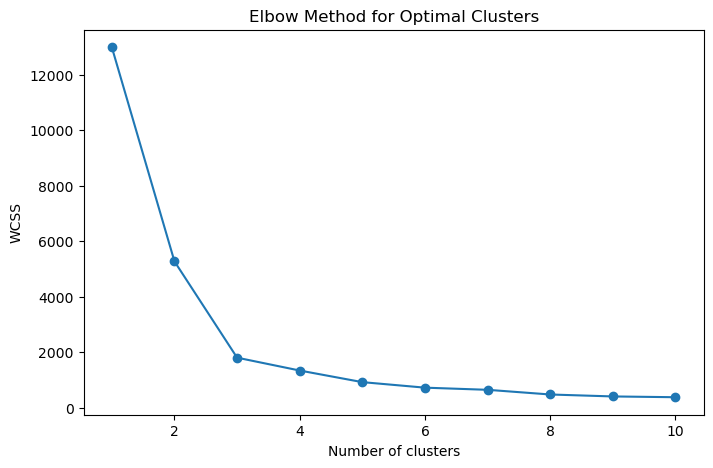

Cluster Summary:
        Recency Frequency   Monetary      
           mean      mean       mean count
Cluster                                   
0          32.4       5.4     2633.8  2915
1           1.0    1363.0  1691524.5     1
2         295.8       1.3      487.8   616
3         155.7       2.2      783.0   798


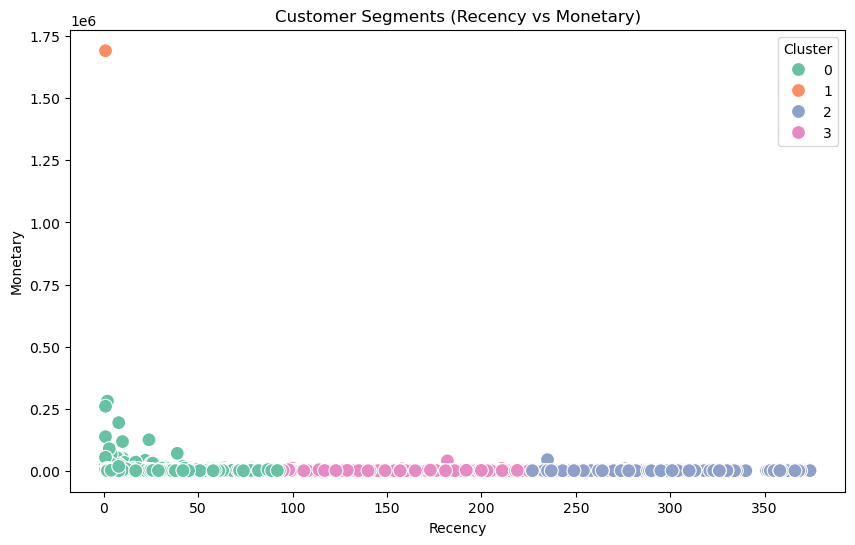

In [1]:
!pip install seaborn openpyxl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Load the cleaned dataset
df = pd.read_excel("../data/cleaned_retail.xlsx", engine="openpyxl")

# Optional: filter out Cancellations
df_filtered = df[df['CancellationFlag'].isnull() | (df['CancellationFlag'].astype(str).str.strip() == '')]

# Filter out cancelled transactions
df_clean = df[df['CancellationFlag'].isnull() | (df['CancellationFlag'].astype(str).str.strip() == '')]

# Create TotalPrice column
df_clean['TotalPrice'] = df_clean['Quantity'] * df_clean['UnitPrice']

# Reference date for Recency
reference_date = df_clean['InvoiceDate'].max() + timedelta(days=1)

# RFM aggregation
rfm = df_clean.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                     # Frequency
    'TotalPrice': 'sum'                                         # Monetary
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# -------------------------------
# Step 2: RFM scoring (optional)
# -------------------------------
rfm['R_score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])
rfm['F_score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
rfm['M_score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5])
rfm['RFM_score'] = rfm['R_score'].astype(str) + rfm['F_score'].astype(str) + rfm['M_score'].astype(str)

# -------------------------------
# Step 3: K-Means clustering
# -------------------------------
# Features for clustering
X = rfm[['Recency', 'Frequency', 'Monetary']]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determine optimal number of clusters (Elbow Method)
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plot Elbow
plt.figure(figsize=(8,5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Fit K-Means (choose n_clusters based on elbow, e.g., 4)
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)
rfm['Cluster'] = kmeans.fit_predict(X_scaled)

# -------------------------------
# Step 4: Cluster profiling
# -------------------------------
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean','count']
}).round(1)

print("Cluster Summary:")
print(cluster_summary)

# -------------------------------
# Step 5: Visualize clusters
# -------------------------------
plt.figure(figsize=(10,6))
sns.scatterplot(
    x='Recency', 
    y='Monetary', 
    hue='Cluster', 
    palette='Set2', 
    data=rfm, 
    s=100
)
plt.title('Customer Segments (Recency vs Monetary)')
plt.show()